# Sparkify Project
## Project overview

Many online services these days provide flexible services to customers which are easy to subscribe to and unsubscribe from. Good examples of such services in the music industry include those such as Spotify and Pandora.

A common problem with these services is trying to anticipate customers who plan to cancel (also known as customer 'churn') with the idea of perhaps encouraging them to stay by providing a special offer, or other incentives. By minimizing customer churn, these services can aim keep more customers happy, and ensure their businesses are more profitable.

For this project, we have a dataset from a music service called Sparkify, very similar to Spotify and Pandora.

## Project definition

Streaming music services can produce huge datasets, and we will approach this project by using one of the most caperble tools for dealing with big data - Apache Spark.

In this project, will analyse the dataset for user logs from the Sparkify service and seek to build a machine learning model that is able to predict customers that might churn.

Our dataset to use is relatively small, but we will stil use Spark so our approach can scale to much bigger datasets.

We will analyse the dataset to find promising features for machine learning, and may also engineer new features that may be useful. We will then explore a range of machine learning models.

To optimise the best results for our relatively small dataset and to help us arrive at the best model that would scale to a bigger dataset, we will use the F1 score as a metric to judge the performance of our models. We will also use cross-validation during model training to best optimise the value of our smaller dataset.

Finally, we will identify the most useful features our models discovered for predicting customer churn.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.types import LongType
from pyspark.sql.functions import desc
from pyspark.sql.functions import udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import first
from pyspark.sql.functions import rank, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from scipy.stats import ttest_ind
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify project") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '45391'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'Sparkify project'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'f9308b7fcf3f'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1560711527522')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load dataset from json
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
# Show schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Get field definitions
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [5]:
# Look at first record
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
# Count how many records we have currently
user_log.count()

286500

In [7]:
# Drop rows with missing user or session id
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid.count()

286500

In [8]:
# Lets have a look to see the remaining user id's
user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
# Remove rows with empty user id
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

In [10]:
# Lets have a look to see the remaining session id's
user_log_valid.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [11]:
# Remove rows with zero ts
user_log_valid = user_log_valid.filter(user_log_valid["ts"] != 0)
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Preliminary data analysis

In [12]:
user_log_valid.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [13]:
user_log_valid.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [14]:
user_log_valid.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [15]:
user_log_valid.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [16]:
user_log_valid.select("page").dropDuplicates().sort("page").show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [17]:
# Number of unique users
unique_users_total = user_log_valid.select('userId').distinct().count()
unique_users_total

225

In [18]:
# Lets look at the first few users
user_log_valid.select('userId').distinct().show(5)

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
+------+
only showing top 5 rows



In [19]:
# Lets look at the logs of a particular user
user_log_valid.select(["userId", "registration", "ts", "page", "song"]).where(user_log_valid.userId == "100010").collect()

[Row(userId='100010', registration=1538016340000, ts=1539003534000, page='NextSong', song='Captain Tyin Knots VS Mr Walkway (No Way)'),
 Row(userId='100010', registration=1538016340000, ts=1539003736000, page='NextSong', song='Beautiful_ Beautiful (Album)'),
 Row(userId='100010', registration=1538016340000, ts=1539003932000, page='NextSong', song="She's Gone"),
 Row(userId='100010', registration=1538016340000, ts=1539003933000, page='Thumbs Up', song=None),
 Row(userId='100010', registration=1538016340000, ts=1539004195000, page='NextSong', song='Folk Bloodbath'),
 Row(userId='100010', registration=1538016340000, ts=1539004511000, page='NextSong', song='Yes'),
 Row(userId='100010', registration=1538016340000, ts=1539004694000, page='NextSong', song='Secrets'),
 Row(userId='100010', registration=1538016340000, ts=1539004918000, page='NextSong', song="You're The One"),
 Row(userId='100010', registration=1538016340000, ts=1539004961000, page='Roll Advert', song=None),
 Row(userId='100010'

In [20]:
user_log_valid.select('artist').distinct().count()

17656

In [21]:
# Check unique values for artist
user_log_valid.select("artist").dropDuplicates().sort("artist").show(40, truncate=False)

+---------------------------------------------------+
|artist                                             |
+---------------------------------------------------+
|null                                               |
|!!!                                                |
|& And Oceans                                       |
|'N Sync/Phil Collins                               |
|'Til Tuesday                                       |
|'t Hof Van Commerce                                |
|'t Hof Van Commerce & Brahim                       |
|(Love) Tattoo                                      |
|(hed) p.e.                                         |
|*NSYNC featuring Nelly                             |
|+ / - {Plus/Minus}                                 |
|+44                                                |
|-123 minut                                         |
|-123min.                                           |
|...And Oceans                                      |
|...And You Will Know Us By 

In [22]:
# Check unique values for auth
user_log_valid.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [23]:
# Show unique values for gender
user_log_valid.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [24]:
# Show unique values for level
user_log_valid.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [25]:
# Show unique values for method
user_log_valid.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



### Defining Churn

In [26]:
# Add new churn column - set default to 0
user_log_valid = user_log_valid.withColumn("churn", lit(0))
user_log_valid.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+---------------

In [27]:
# Find users who cancelled
churned = user_log_valid.filter("page = 'Cancellation Confirmation'")
churned.show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    0|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5

In [28]:
# Find unique users that cancelled
churned_userids = churned.select('userId').distinct()
# Convert to list
churned_userids_list = list(churned_userids.select('userId').toPandas()['userId'])
# How many users cancelled & stayed?
unique_users_cancelled = len(churned_userids_list)
unique_users_stayed = unique_users_total - unique_users_cancelled
print(unique_users_cancelled)
print(unique_users_stayed)

52
173


In [29]:
# Show cancelled user ids
churned_userids_list

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [30]:
# Get logs of churned users
user_log_valid_churned = user_log_valid.filter(col("userId").isin(churned_userids_list))
# Set churn 1 for churned users
user_log_valid_churned = user_log_valid_churned.withColumn("churn", lit(1))
# Get logs of stayed users
user_log_valid_stayed = user_log_valid.filter(~col("userId").isin(churned_userids_list))
# Print churned users, check flag set
user_log_valid_churned.show(2)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|        Modjo|Logged In|    Alexi|     F|            0|  Warren|250.93179| paid|Spokane-Spokane V...|   PUT|NextSong|1532482662000|       53|         What I Mean|   200|1538353930000|Mozilla/5.0 (Wind...|    54|    1|
|Edwyn Collins|Logged In|    Alexi|     F|            1|  Warren|  216.842| paid|Spokane-Spokane V...|   PUT|NextSong|153248

In [31]:
# Merge churn labelled sub-sets back into main log df
user_log_valid = user_log_valid_churned.union(user_log_valid_stayed)
# Print all user logs total again
print(user_log_valid.count())
# Print number of churned users logs
print(user_log_valid_churned.count())
# Print number of non-churned users logs
print(user_log_valid_stayed.count())

278154
44864
233290


### Explore churned v stayed user sub-groups

We will now explore various features in the dataset to see if any of them reveal any significant differences between users that churn and users that stay.

#### Explore songs played per hour

Does one group play more songs per hour than the other group?

In [32]:
# Calculate songs played per hour for each group
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
# Create hour column
user_log_valid_churned = user_log_valid_churned.withColumn("hour", get_hour(user_log_valid_churned.ts))
user_log_valid_stayed = user_log_valid_stayed.withColumn("hour", get_hour(user_log_valid_stayed.ts))

In [33]:
# Calculate songs played per hour
songs_in_hour_churned = user_log_valid_churned.filter(user_log_valid_churned.page == "NextSong").groupby(user_log_valid_churned.hour).count().orderBy(user_log_valid_churned.hour.cast("float"))
songs_in_hour_stayed = user_log_valid_stayed.filter(user_log_valid_stayed.page == "NextSong").groupby(user_log_valid_stayed.hour).count().orderBy(user_log_valid_stayed.hour.cast("float"))
# Convert songs per hour results to pandas df
songs_in_hour_churned_pdf = songs_in_hour_churned.toPandas()
songs_in_hour_churned_pdf.hour = pd.to_numeric(songs_in_hour_churned_pdf.hour)
songs_in_hour_stayed_pdf = songs_in_hour_stayed.toPandas()
songs_in_hour_stayed_pdf.hour = pd.to_numeric(songs_in_hour_stayed_pdf.hour)
# Scale by number of users in each group
songs_in_hour_churned_pdf['count'] = songs_in_hour_churned_pdf['count'].apply(lambda x: x // unique_users_cancelled)
songs_in_hour_stayed_pdf['count'] = songs_in_hour_stayed_pdf['count'].apply(lambda x: x // unique_users_stayed)


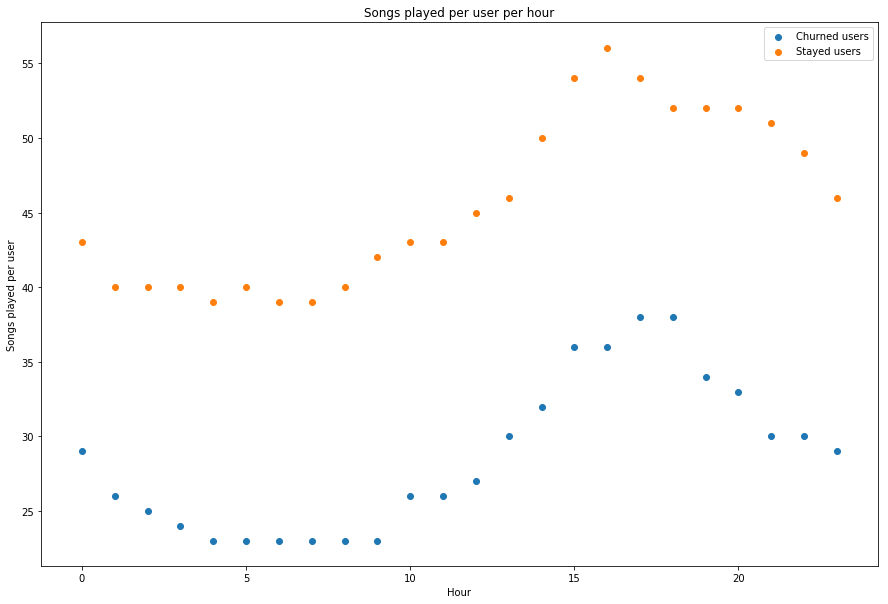

In [34]:
# Plot each groups songs per hour on graph
plt.figure(figsize=(15,10))
plt.scatter(songs_in_hour_churned_pdf["hour"], songs_in_hour_churned_pdf["count"], label='Churned users')
plt.scatter(songs_in_hour_stayed_pdf["hour"], songs_in_hour_stayed_pdf["count"], label='Stayed users')
plt.xlabel("Hour")
plt.ylabel("Songs played per user");
plt.title("Songs played per user per hour");
plt.legend();

In [35]:
# Calculate difference of mean songs per hour per user for each group
mean_usersongs_per_hour_churned = songs_in_hour_churned_pdf['count'].mean()
mean_usersongs_per_hour_stayed = songs_in_hour_stayed_pdf['count'].mean()
diff_means_usersongs_per_hour = mean_usersongs_per_hour_stayed - mean_usersongs_per_hour_churned
# Print means & diff means
print(mean_usersongs_per_hour_stayed)
print(mean_usersongs_per_hour_churned)
print(diff_means_usersongs_per_hour)

45.625
28.625
17.0


So there seems to be a big difference in the mean songs played per hour between the two groups of users - but how can we be sure it's significant?

We know from the central limit theorem that these sample means should come from a normal distribution, therefore we can use a parametric t-test on the data to see if the difference in means is significant i.e. that users that stay do actually play more songs per hour than users who churn.

We will perform a 2-sided (unpaired) t-test on the churned v stayed users mean played songs per hour, with the null hypothesis being there is no significant difference between the users - and the alternate being that there is a significant difference between the users.

We will choose a significance level (alpha) of 0.05 for our p-value to judge the result.

In [36]:
# Peform t test on both groups
stat, p = ttest_ind(songs_in_hour_stayed_pdf['count'].tolist(), songs_in_hour_churned_pdf['count'].tolist())
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=10.866, p=0.000


So while users that churned & users that stayed have a similar pattern of usage per hour, we can see with a p-value of 0 less than our alpha of 0.05, this seems to confirm that there is a significant difference in mean songs played per hour between users that churn and users that stay.

Therefore 'mean songs per hour' might be a useful feature for our model to predict user churn.

#### Explore actions per user

Let us now compare the number of actions taken on average pers user per group.

In [37]:
# Re-cap the types of actions available
user_log_valid.select("page").dropDuplicates().sort("page").show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



                  churned  stayed
page                             
About                   1       2
Add Friend             12      21
Add to Playlist        19      31
Downgrade               6       9
Error                   0       1
Help                    4       7
Home                   32      48
Logout                 10      15
NextSong              699    1108
Roll Advert            18      17
Save Settings           1       1
Settings                5       7
Submit Downgrade        0       0
Submit Upgrade          0       0
Thumbs Down             9      11
Thumbs Up              35      61
Upgrade                 2       2


Text(0.5,1,'Mean actions per user')

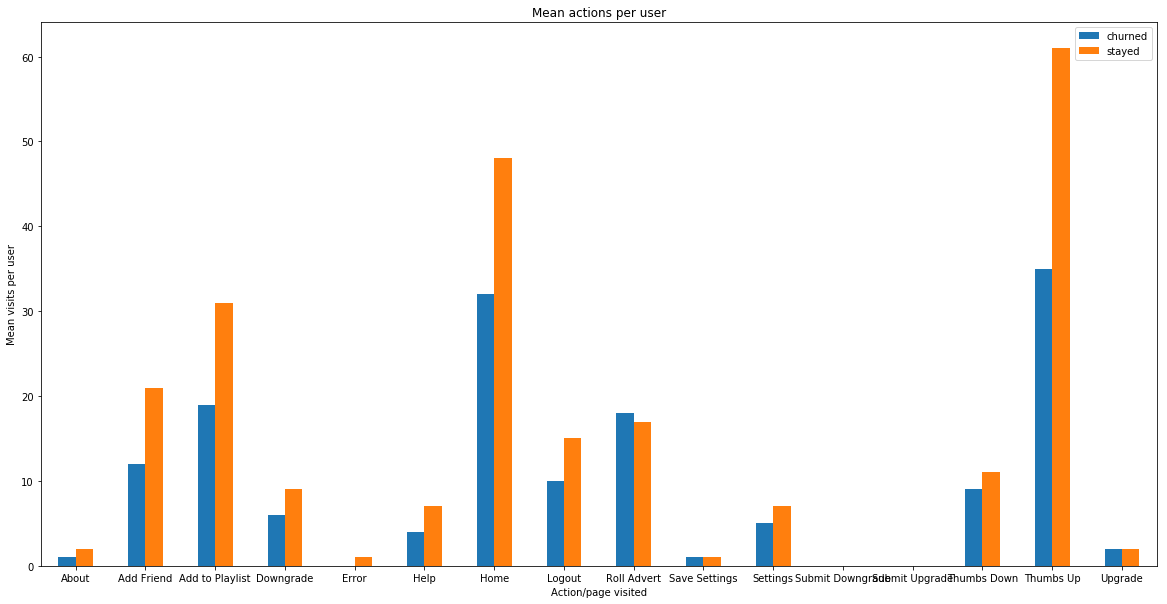

In [38]:
# Get total actions per group
actions_churned_count = user_log_valid_churned.groupby(user_log_valid_churned.page).count().orderBy(user_log_valid_churned.page)
actions_stayed_count = user_log_valid_stayed.groupby(user_log_valid_stayed.page).count().orderBy(user_log_valid_stayed.page)

# Convert churned into pandas df
actions_churned_count_pdf = actions_churned_count.toPandas()
actions_churned_count_pdf.columns = ['page', 'churned']
# Scale by number of users in churned group
actions_churned_count_pdf['churned'] = actions_churned_count_pdf['churned'] // unique_users_cancelled
# Convert stayed into pandas df
actions_stayed_count_pdf = actions_stayed_count.toPandas()
actions_stayed_count_pdf.columns = ['page', 'stayed']
# Scale by number of users in stayed group
actions_stayed_count_pdf['stayed'] = actions_stayed_count_pdf['stayed'] // unique_users_stayed

# Merge both groups into single df
actions_count_pdf = pd.merge(actions_churned_count_pdf, actions_stayed_count_pdf, on='page')
actions_count_pdf = actions_count_pdf.set_index('page')

# Show all values
print(actions_count_pdf.head(20))
# The values for 'NextSong' are huge and will prevent us from seeing the other values clearly on chart, so lets remove
actions_count_pdf = actions_count_pdf.drop(['NextSong'])
# Plot remaining values for actions from both groups
ax = actions_count_pdf.plot.bar(rot=0, figsize=(20,10))
ax.set_xlabel("Action/page visited")
ax.set_ylabel("Mean visits per user")
ax.set_title("Mean actions per user")

So when comparing both groups, we can see the stayed group has significantly bigger values for the following pages/actions:

- NextSong
- Add Friend
- Add to Playlist
- Home
- Thumbs up

This might suggest these would be good features for our model for helping to distingush & predict users likely to churn. However we may need to add another feature that helps account for length of time e.g. days since signup, this will allow the model to distinguish a user that has visted these pages a little but of a longer time (so has a big total) compared to another user who has visted these pages a lot in a shorter space of time.

#### Explore length per user

I assume this means length of time each logged activity takes? for example if a user gets a poor service i.e. a slow connection & slow service - is this a good predictor if someone will churn?

In [39]:
# Get lengths per group
user_log_valid_churned.describe("length").show()
user_log_valid_stayed.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             36394|
|   mean|248.63279564406366|
| stddev|102.38497717575474|
|    min|           4.04853|
|    max|        3024.66567|
+-------+------------------+

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            191714|
|   mean|249.20913538881427|
| stddev|  98.6258830014688|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



There does not seem to be a significant difference in the distribution of values for for length between churned and stayed users.

#### Explore status per user

These seem to be the (HTTP) status codes for each logged event/activity for success (200), failure (404) or temporary redirect (307) are these perhaps good predictors if someone will churn?

        churned  stayed
status                 
200         791    1234
307          71     112
404           0       1


Text(0.5,1,'Mean HTTP Status for events per user')

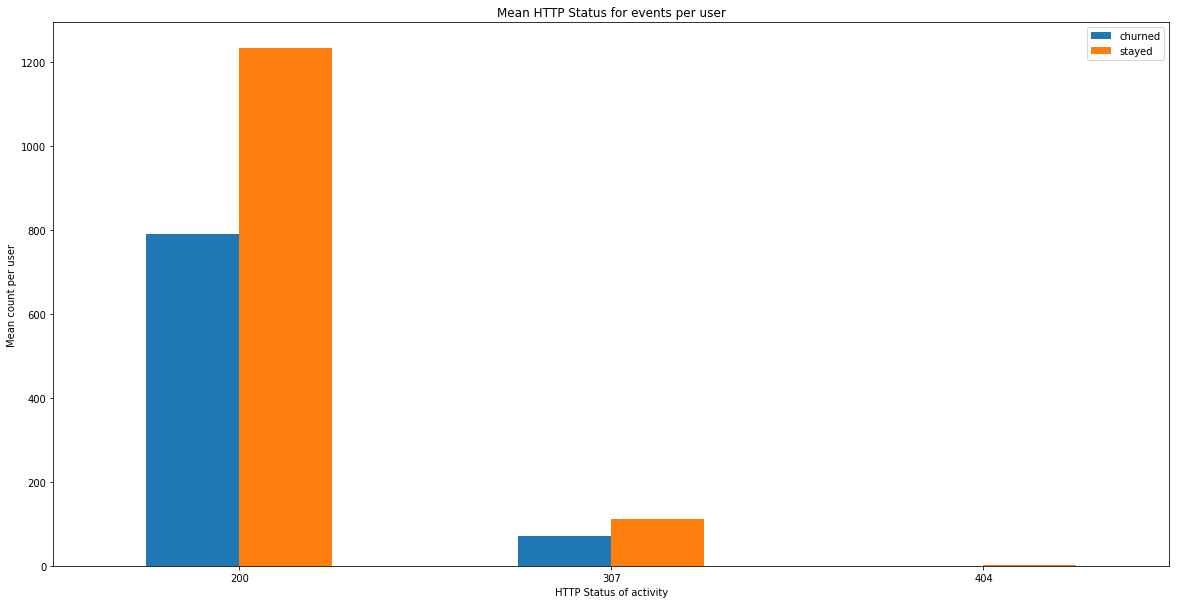

In [40]:
# Get total status per group
status_churned_count = user_log_valid_churned.groupby(user_log_valid_churned.status).count().orderBy(user_log_valid_churned.status)
status_stayed_count = user_log_valid_stayed.groupby(user_log_valid_stayed.status).count().orderBy(user_log_valid_stayed.status)

# Convert churned into pandas df
status_churned_count_pdf = status_churned_count.toPandas()
status_churned_count_pdf.columns = ['status', 'churned']
# Scale by number of users in churned group
status_churned_count_pdf['churned'] = status_churned_count_pdf['churned'] // unique_users_cancelled
# Convert stayed into pandas df
status_stayed_count_pdf = status_stayed_count.toPandas()
status_stayed_count_pdf.columns = ['status', 'stayed']
# Scale by number of users in stayed group
status_stayed_count_pdf['stayed'] = status_stayed_count_pdf['stayed'] // unique_users_stayed

# Merge both groups into single df
status_count_pdf = pd.merge(status_churned_count_pdf, status_stayed_count_pdf, on='status')
status_count_pdf = status_count_pdf.set_index('status')

# Show all values
print(status_count_pdf.head(20))
# Plot remaining values for status from both groups
ax = status_count_pdf.plot.bar(rot=0, figsize=(20,10))
ax.set_xlabel("HTTP Status of activity")
ax.set_ylabel("Mean count per user")
ax.set_title("Mean HTTP Status for events per user")

It would seem then that users that stay get on average more '200' success status values than those that churn. This could of course simply be due to what we observed earlier, that users who tend to stay tend to use the service more. 

However there could be other reasons. I may well choose to include the 200 value as a feature for the model.

#### Explore gender per user

Is one gender more likely to churn than the other?

Churned users
+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

Stayed users
+------+-----+
|gender|count|
+------+-----+
|     F|   84|
|     M|   89|
+------+-----+

        churned  stayed
gender                 
F            20      84
M            32      89


Text(0.5,1,'Gender of churned v staying users')

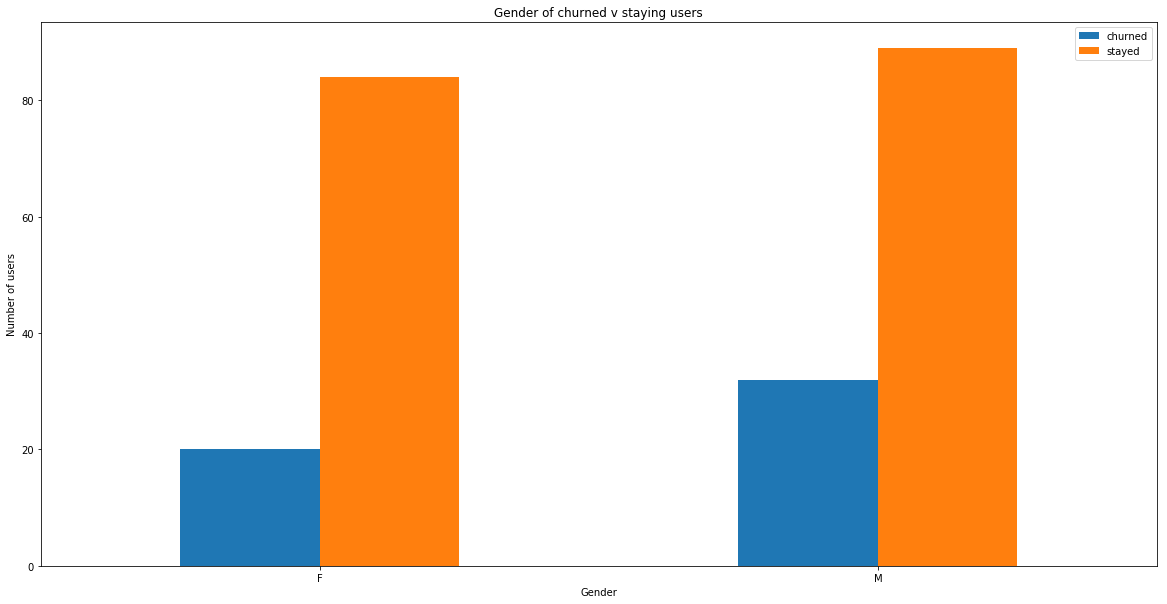

In [41]:
# Get total gender per group
gender_churned_count = user_log_valid_churned.select('userId', 'gender').distinct().groupby(user_log_valid_churned.gender).count()
gender_stayed_count = user_log_valid_stayed.select('userId', 'gender').distinct().groupby(user_log_valid_stayed.gender).count()

# Print churned & stayed totals
print("Churned users")
gender_churned_count.show()
print("Stayed users")
gender_stayed_count.show()

# Convert churned into pandas df
gender_churned_count_pdf = gender_churned_count.toPandas()
gender_churned_count_pdf.columns = ['gender', 'churned']
# Convert stayed into pandas df
gender_stayed_count_pdf = gender_stayed_count.toPandas()
gender_stayed_count_pdf.columns = ['gender', 'stayed']

# Merge both groups into single df
gender_count_pdf = pd.merge(gender_churned_count_pdf, gender_stayed_count_pdf, on='gender')
gender_count_pdf = gender_count_pdf.set_index('gender')

# Show all values
print(gender_count_pdf.head())
# Plot remaining values for gender from both groups
ax = gender_count_pdf.plot.bar(rot=0, figsize=(20,10))
ax.set_xlabel("Gender")
ax.set_ylabel("Number of users")
ax.set_title("Gender of churned v staying users")

The proportions of males to females for both groups seems roughly similar, so we will not use this as a feature for our model.

#### Days registered

Does the number of days since a user signed up make a userful predictor for if that user will churn?

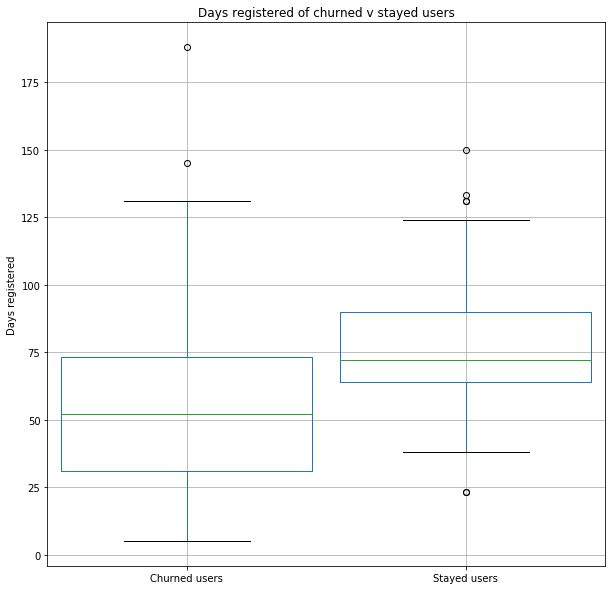

In [42]:
# Create window function to get rank of each row from logs based on userid and timestamp (ts)
window_churned = Window.partitionBy(user_log_valid_churned['userId']).orderBy(user_log_valid_churned['ts'].desc())
window_stayed = Window.partitionBy(user_log_valid_stayed['userId']).orderBy(user_log_valid_stayed['ts'].desc())
# Now filter results using window function and only keep top 1 at most 
# i.e. Create new sdf of last log entry per user
last_log_user_churned = user_log_valid_churned.select("*", rank().over(window_churned).alias('rank')).filter(col('rank') <= 1)
last_log_user_stayed = user_log_valid_stayed.select("*", rank().over(window_stayed).alias('rank')).filter(col('rank') <= 1)
# Create lambda function to calculate new feature for days since registration
calc_days_registered = udf(lambda reglog, lastlog: (datetime.datetime.fromtimestamp(lastlog/1000) - datetime.datetime.fromtimestamp(reglog/1000)).days)
# Apply lambda to create days since registration
last_log_user_churned = last_log_user_churned.withColumn("days_registered", calc_days_registered(last_log_user_churned.registration, last_log_user_churned.ts))
last_log_user_stayed = last_log_user_stayed.withColumn("days_registered", calc_days_registered(last_log_user_stayed.registration, last_log_user_stayed.ts))
# Convert to float
last_log_user_churned = last_log_user_churned.withColumn("days_registered", last_log_user_churned.days_registered.cast('float'))
last_log_user_stayed = last_log_user_stayed.withColumn("days_registered", last_log_user_stayed.days_registered.cast('float'))

# Convert to pandas df
last_log_user_churned_df = last_log_user_churned.toPandas()
last_log_user_stayed_df = last_log_user_stayed.toPandas()
# Create box plots comparing days registered for churned v stayed users
days_registered_compare = pd.DataFrame()
days_registered_compare['Churned users'] = last_log_user_churned_df['days_registered'] 
days_registered_compare['Stayed users'] = last_log_user_stayed_df['days_registered'] 
days_registered_compare.boxplot(figsize=(10,10), grid=True, widths=0.9)
plt.title('Days registered of churned v stayed users')
plt.ylabel('Days registered')
plt.show()

It seems like churned users are registered for a lower number of days, the distribution of values is clearly lower for these users. Therefore, days registered could well be a useful predictor for user churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [57]:
def engineer_user_features(user_logs_sdf):
    """
    Create features for ML model from source spark dataframe
    
    INPUT: Source spark dataframe - individual rows per log event
    OUTPUT: Spark dataframe with engineered features ready for model - individual rows per unique user
    """
    
    # PAGE FEATURES
    # Create new sdf aggregation counts from logs by user and by page
    users_sdf = user_logs_sdf.groupby("userId", "page").count()
    # Group by userid & pivot page types & sum count to create one row of page feature counts per userId
    users_sdf = users_sdf.groupby("userId").pivot("page").sum('count')
    # Keep only the most promising page types
    users_sdf = users_sdf.select(["userId", "NextSong", "Add Friend", "Add to Playlist", "Home", "Thumbs Up"])
    # Replace nulls with zeros - ready for calculations etc..
    users_sdf = users_sdf.na.fill(0)
    
    
    # DAYS REGISTERED FEATURE
    # Create window function to get rank of each row from logs based on userid and timestamp (ts)
    window = Window.partitionBy(user_logs_sdf['userId']).orderBy(user_logs_sdf['ts'].desc())
    # Now filter results using window function and only keep top 1 at most 
    # i.e. Create new sdf of last log entry per user
    last_log_user = user_logs_sdf.select("*", rank().over(window).alias('rank')).filter(col('rank') <= 1)
    # Create lambda function to calculate new feature for days since registration
    calc_days_registered = udf(lambda reglog, lastlog: (datetime.datetime.fromtimestamp(lastlog/1000) - datetime.datetime.fromtimestamp(reglog/1000)).days)
    # Apply lambda to create days since registration
    last_log_user = last_log_user.withColumn("days_registered", calc_days_registered(last_log_user.registration, last_log_user.ts))
    # Convert to float
    last_log_user = last_log_user.withColumn("days_registered", last_log_user.days_registered.cast('float'))
    # Remove redundant columns
    last_log_user = last_log_user.select(["userId", "days_registered"])
    # Create days registered feature by inner join
    users_sdf = users_sdf.join(last_log_user, users_sdf["userId"] == last_log_user["userId"]).drop(last_log_user["userId"])
    # Remove any duplicates created by join
    users_sdf = users_sdf.dropDuplicates()
    
    
    # CHURN TARGET FEATURE
    # Find unique users that cancelled
    churned_sdf = user_logs_sdf.filter("page = 'Cancellation Confirmation'")
    churned_sdf = churned_sdf.select('userId').distinct()
    # Add new churn column - set default to 1
    churned_sdf = churned_sdf.withColumn("churn", lit(1))
    # Left join churned sdf on users sdf
    users_sdf = users_sdf.join(churned_sdf, users_sdf["userId"] == churned_sdf["userId"], "left").drop(churned_sdf["userId"])
    # Replace null values in churned column with 0
    users_sdf = users_sdf.na.fill({'churn': 0})
    
    
    # NORMALISE FEATURES
    cols = ["NextSong", "Add Friend", "Add to Playlist", "Home", "Thumbs Up", "days_registered"]
    # Create feature vector assembler
    vector_assembler = VectorAssembler(inputCols=cols, outputCol="FeatureVector")
    # Transform features into dense vector feature
    users_sdf = vector_assembler.transform(users_sdf)
    # Normalise feature vector
    scaler = Normalizer(inputCol="FeatureVector", outputCol="ScaledFeatureVector")
    users_sdf = scaler.transform(users_sdf)
    
    
    # Return resulting sdf
    return users_sdf

users_sdf = engineer_user_features(user_log_valid)
users_sdf.head(1)

[Row(NextSong=275, Add Friend=4, Add to Playlist=7, Home=11, Thumbs Up=17, userId='100010', days_registered=55.0, churn=0, FeatureVector=DenseVector([275.0, 4.0, 7.0, 11.0, 17.0, 55.0]), ScaledFeatureVector=DenseVector([0.9776, 0.0142, 0.0249, 0.0391, 0.0604, 0.1955]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Split data

In [44]:
# Change column names of data for training & testing
data = users_sdf.select(col("churn").alias("label"), col("ScaledFeatureVector").alias("features"))
# Split data into train + validation and test sets
rest, test = data.randomSplit([0.8, 0.2], seed=42)
train, validation = rest.randomSplit([0.6, 0.4], seed=42)

#### Baseline/naive predictor

Let is recap how many users churned v how many stayed.

In [45]:
users_churned = user_log_valid_churned.count()
users_stayed = user_log_valid_stayed.count()
# Print number of churned users logs
print(users_churned)
# Print number of non-churned users logs
print(users_stayed)
# Print proportion churned v stayed
print(users_churned / users_stayed)

44864
233290
0.19231000042865104


So most users stayed (around 19% churned). Lets define the naive predictor as one that predicts all users stayed (i.e. churn = 0) and derive an F1 score that will be our baseline F1 score.

In [46]:
results_base = test.withColumn('prediction', lit(0.0))
metrics = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Naive predictor metrics:')
print('F-1 Score:{}'.format(metrics.evaluate(results_base, {metrics.metricName: "f1"})))

Naive predictor metrics:
F-1 Score:0.5841784989858012


So our naive predictor has a score of 0.58 to beat.

#### Model criteria

It is envisaged that the model could be used on a periodic basis (run daily, or weekly) to identify user that churn.

Given our relatively small dataset, in order to get the best model from our data that maximises our correct classifications while also minimizing our incorrect classifications - the F1 score is a convenient measure that aims to measure both of these in one single metric.

Therefore, our main objective is to have a model that has the best predictive performance (as defined by the F1 score). While speed of training of the model is a lesser consideration we will also take note of this in our comparison between model results.

#### Model agnostic components

Lets define some model components that we will use for all of our models.

In [47]:
# Define metric to optimise cross-fold validation training
f1_score = MulticlassClassificationEvaluator(metricName='f1')
# Define parameters for cross-fold validation
paramGrid = ParamGridBuilder() \
    .build()

#### Logistic regression

In [75]:
# Create model
logistic_regression = LogisticRegression()
# Create cross-fold validation object with model
crossval_lr = CrossValidator(estimator=logistic_regression,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)
# Train model using cross-fold validation
training_start = time()
cv_lr_model = crossval_lr.fit(train)
training_end = time()
print('The training process took {} seconds'.format(training_end - training_start))

The training process took 489.0117049217224 seconds


In [76]:
# Validate model
results_lr = cv_lr_model.transform(validation)
# Show metrics
print('Logistic regression metrics:')
print('F-1 Score:{}'.format(metrics.evaluate(results_lr, {metrics.metricName: "f1"})))

Logistic regression metrics:
F-1 Score:0.6644736842105263


#### Random forrest

In [77]:
# Create model
random_forrest = RandomForestClassifier()
# Create cross-fold validation object with model
crossval_rf = CrossValidator(estimator=random_forrest,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)
# Train model using cross-fold validation
training_start = time()
cv_rf_model = crossval_rf.fit(train)
training_end = time()
print('The training process took {} seconds'.format(training_end - training_start))

The training process took 402.4907035827637 seconds


In [78]:
# Validate model
results_rf = cv_rf_model.transform(validation)
# Show metrics
print('Random forrest metrics:')
print('F-1 Score:{}'.format(metrics.evaluate(results_rf, {metrics.metricName: "f1"})))

Random forrest metrics:
F-1 Score:0.7000095751811305


#### Gradient boosted tree

In [79]:
# Create model
gradient_boosted_tree = GBTClassifier()
# Create cross-fold validation object with model
crossval_gbt = CrossValidator(estimator=gradient_boosted_tree,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score,
                          numFolds=3)
# Train model using cross-fold validation
training_start = time()
cv_gbt_model = crossval_gbt.fit(train)
training_end = time()
print('The training process took {} seconds'.format(training_end - training_start))

The training process took 1453.1155021190643 seconds


In [80]:
# Validate model
results_gbt = cv_gbt_model.transform(validation)
# Show metrics
print('Gradient boosted tree metrics:')
print('F-1 Score:{}'.format(metrics.evaluate(results_gbt, {metrics.metricName: "f1"})))

Gradient boosted tree metrics:
F-1 Score:0.6935672514619883


#### Model comparison and evaluation

For us the F1 score is the key determining factor, and random forrest is the model that comes out best with default parameters scoring 0.7. In addition, it also has the fastest training time of 402 seconds. So we will use random forrest as our best model to go forward to fine tune the hyper-parameters.

#### Model tuning

In [48]:
# Create model
random_forrest = RandomForestClassifier()
# Define parameters for cross-fold validation & hyper-parameter tuning
paramGrid2 = ParamGridBuilder() \
    .addGrid(random_forrest.numTrees, [10, 20, 30]) \
    .addGrid(random_forrest.maxDepth, [3, 5, 10]) \
    .build()

# Create cross-fold validation object with model
crossval_rf2 = CrossValidator(estimator=random_forrest,
                          estimatorParamMaps=paramGrid2,
                          evaluator=f1_score,
                          numFolds=3)
# Train model using cross-fold validation
training_start = time()
cv_rf2_model = crossval_rf2.fit(train)
training_end = time()
print('The training process took {} seconds'.format(training_end - training_start))

The training process took 1404.8262615203857 seconds


In [49]:
# Validate final best model
bestModel = cv_rf2_model.bestModel
results_rf2 = bestModel.transform(validation)
# Show metrics
print('Random forrest metrics - validation:')
print('F-1 Score:{}'.format(metrics.evaluate(results_rf2, {metrics.metricName: "f1"})))

Random forrest metrics - validation:
F-1 Score:0.79003359462486


In [50]:
# Check using separate test set - sanity check
results_rf3 = bestModel.transform(test)
# Show metrics
print('Random forrest metrics - test:')
print('F-1 Score:{}'.format(metrics.evaluate(results_rf3, {metrics.metricName: "f1"})))

Random forrest metrics - test:
F-1 Score:0.6288515406162466


In [56]:
# Print number of observations in train, validation & test sets
print(train.count())
print(validation.count())
print(test.count())

134
57
34


We should note again that this is a relatively small dataset (225 user account observations).

Also our proportions of train, validation and test datasets were:

- Train (134) - 48%
- Validation (57) - 32%
- Test (34) - 20%

Our final validation F1 score was 0.79, while our final test F1 score on data the model had never seen was 0.62. Recall our naieve predictor F1 score was 0.58.

The question is - which of these scores for our model is more likely accurate? Our test score might give us pause for caution about our validation score being as high. On the other hand, the test score is on a very few observations (34). However both are better than the naive predictor, so we can be more confident at least that the model is offering some improvement over that.

Training over a bigger dataset will yield more conclusive results, but given the performance on this dataset - overall given the best F1 score and the performance advantage in terms of training speed - I would still recommend using the Random Forrest model for use in bigger versions of this dataset.

### Feature importance

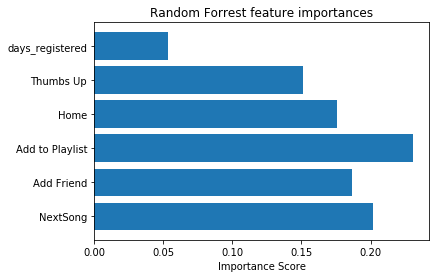

In [51]:
# Get feature importance values
feature_importances = bestModel.featureImportances.values
cols = ["NextSong", "Add Friend", "Add to Playlist", "Home", "Thumbs Up", "days_registered"]
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feature_importances, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('Random Forrest feature importances');

It is interesting to observe that the most useful feature for the model was in fact 'Add to playlist'. It should be noted though than most of the other 'action' features used were close behind. 

It is also curious to note that the days registered feature was the least useful feature for the model. This suggests that measures of user activity are generally better predictors of user churn than number of days registered.

## Conclusion

In this project we looked at our limited dataset of 225 users, and identified promising features for predicting user churn as well as engineering other features (such as days registered).

Our most promising model was the Random Forrest classifier, which had a final validation score of 0.79. It should also be noted that a subsequent evaluation on a separate test set never seen produced a lower score of 0.62. This throws some caution on validation score of 0.79, however the smallness of the dataset as a whole and in particular this separate test set should also be noted.

It was certainly very useful to have a separate test set of data to question the validity of the performance of our model - even if we cannot be entirely certain of how much confidence we should place on this.

Nevertheless, this model and features developed seem to be good candidates for further exploration on bigger datasets, which would also yeild more conclusive results on our approach. It is my belief that on a bigger dataset, the disparity between the validation and test score would be much smaller, giving us more confidence in the performance of the model on an ongoing basis for larger datasets and more users for predicting churn more accurately.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.